In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## Import data

In [237]:
df = pd.read_csv("restaurants_visitors (prueba).csv",parse_dates=['visit_date','visit_datetime','reserve_datetime'])

## Transform data

In [238]:
df['visit_date']=df['visit_date'].fillna(df['visit_datetime'].dt.date)
df['Month'] = df['visit_date'].dt.month
df['Year'] = df['visit_date'].dt.year

In [239]:
df_grouped = df.groupby(df['visit_date'].dt.to_period('D'))['reserve_visitors'].sum()
df_grouped.index = df_grouped.index.to_timestamp()

## Exploratory analysis

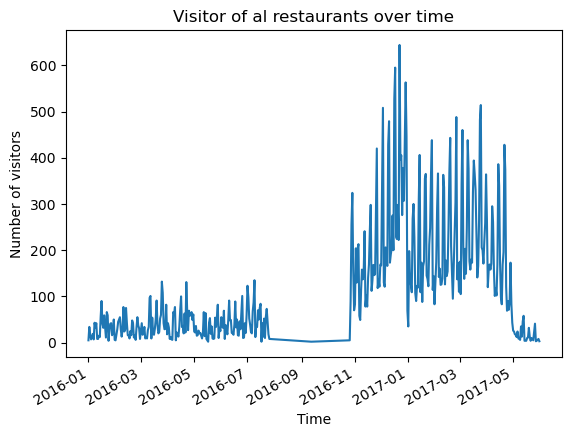

In [240]:
df_grouped.plot()
plt.title('Visitor of all restaurants over time')
plt.xlabel('Time')
plt.ylabel('Number of visitors')
plt.show()

## Modeling

### 1) Varianze stabilization (Box-Cox transformation)

In [241]:
yt,lambda_ = stats.boxcox(df_grouped)
yt=pd.Series(yt,index=df_grouped.index)
lambda_

0.14155575621570318

We see that the lambda used for the tranformation is different from 0 wich we can say that the varianze in the raw data is not stabilized and we will use lambda = 0.1415 to stabilize it.

### 2) Mean stabilization (making it stationary)

In [242]:
result_1 = adfuller(yt)
print('ADF Statistic:', result_1[0])
print('p-value:', result_1[1])

ADF Statistic: -1.328281771309582
p-value: 0.6161361177410183


What the Ad fuller test is telling us is that the data is not stationary and we require to transform it, we perform the first difference to make it statiotionary and test it

ADF Statistic: -9.842771971528883
p-value: 4.7052752102235943e-17


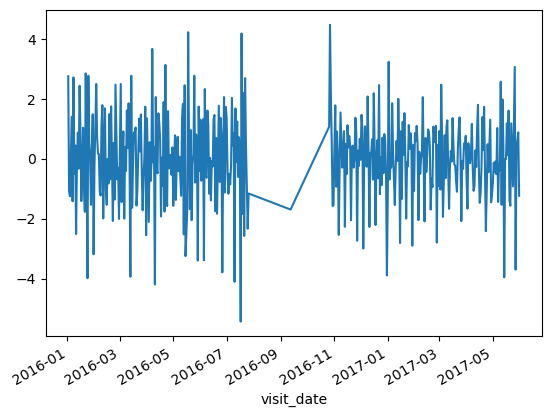

In [243]:
yt_stationary = yt.diff().dropna()

result_diff = adfuller(yt_stationary)
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])
fig, ax = plt.subplots()
yt_stationary.plot(ax=ax)
plt.show()


We can see by the graph and the p-value less than 5% our data is now stationary and we can continue with the model. Given that we only required 1 difference to obtain a p-value less than 5% in the Ad fuller test, we can set the Integrated part of our model as d = 1.

### 3) Autocorrelation and partial autocorrelation function.

We will use this plots to obtain q and p, paramethers for the ARIMA model.

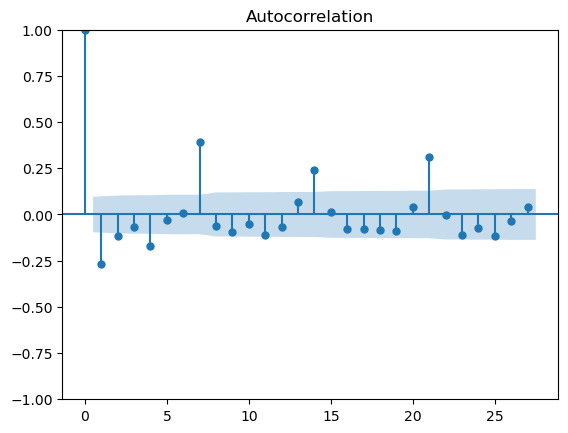

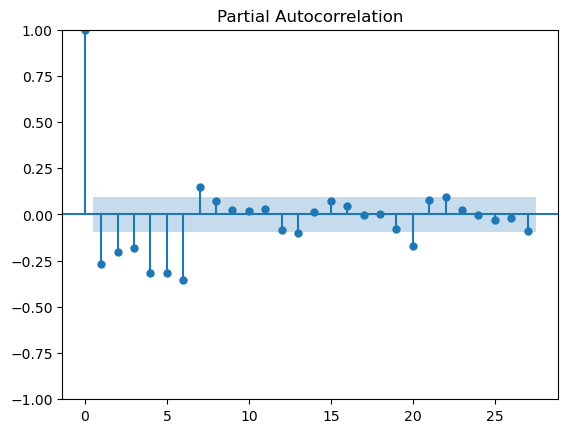

In [244]:
acf = plot_acf(yt_stationary)
pacf = plot_pacf(yt_stationary)

Given that in the Autocorrelation plot the last lag that goes out of the confidence band that is closest to the origin is the second one, I set q = 2; additionaly, for the partial autocorrelation I set p = 6.

In [282]:
model = ARIMA(df_grouped, order = (6,1,2))
model_fit = model.fit()
model_fit.summary()

c:\Users\alons\anaconda3\envs\dashapp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alons\anaconda3\envs\dashapp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alons\anaconda3\envs\dashapp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alons\anaconda3\envs\dashapp\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('N

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       reserve_visitors   No. Observations:                  418
Model:                 ARIMA(6, 1, 2)   Log Likelihood               -2302.959
Date:                Wed, 13 Dec 2023   AIC                           4623.917
Time:                        08:01:46   BIC                           4660.215
Sample:                             0   HQIC                          4638.268
                                - 418                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7840      0.075    -10.395      0.000      -0.932      -0.636
ar.L2         -0.8892      0.048    -18.502      0.000      -0.983      -0.795
ar.L3         -0.8005      0.051    -15.734      0.000      -0.900      -0.701
ar.L4         -0.7721      0.045    -17.062      0.000      -0.861      -0.683
ar.L5         -0.7682      0.034    -22.515      0.000      -0.835      -0.701
ar.L6         -0.5661      0.044    -12.943      0.000      -0.652      -0.480
ma.L1          0.2291      0.073      3.118      0.002       0.085       0.373
ma.L2          0.1876      0.055      3.409      0.001       0.080       0.295
sigma2      3635.9327    152.217     23.887      0.000    3337.594    3934.272
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               951.35
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               5.62   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can see that the p-values of all parameters in our model are less than 5% which means that all of them are statistically different from 0 and we can use them in the model.

## Residual analysis

JB Statistic: 947.6686382650239
p-value: 1.645772739313004e-206


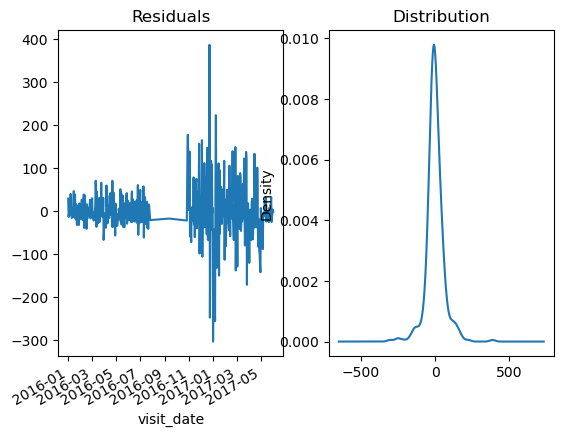

In [283]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Distribution',kind='kde',ax=ax[1])
res_normal_test = stats.jarque_bera(residuals)
print('JB Statistic:', res_normal_test[0])
print('p-value:', res_normal_test[1])

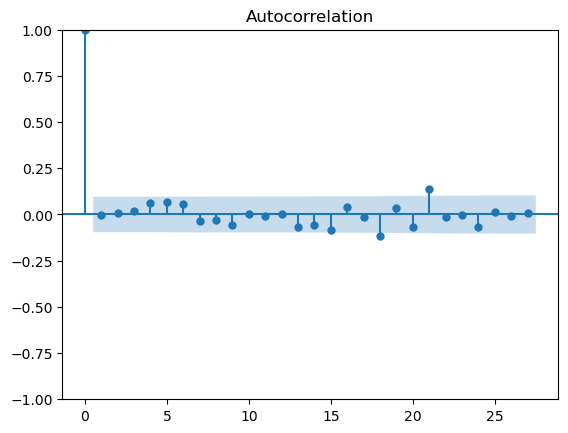

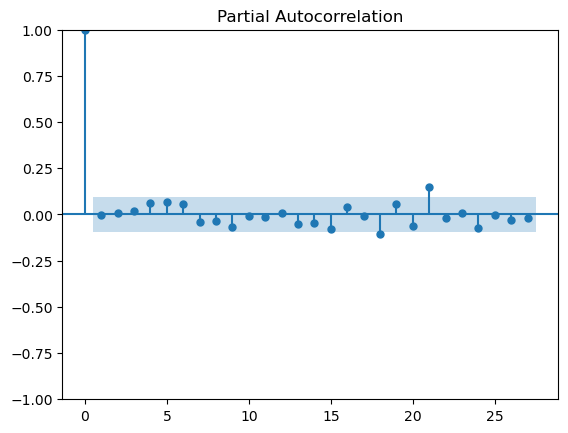

In [284]:
res_acf = plot_acf(residuals)
res_pacf = plot_pacf(residuals)

In the first two graphs we can see the distribution of the the residual, graphicaly we can see that if follows a normal distribution with mean = 0, and by making the Jarque-Bera test we obtain that the p-value is less than 5% with that we can assume that the residuals follow a normal distribution following the assumption of time series; additionally we can see that in the graph of autocorrelation and partial autocorrelation none of the lags closes to the origin go out of the confidence bands, we can conclude that these residuals do not contribute to the model.

## Forecast

In [285]:
days_to_forecast = ((yt_stationary.index[-1] + np.timedelta64(6, 'M')).date() - yt_stationary.index[-1].date()).days

In [302]:
forecast = model_fit.forecast(days_to_forecast)
forecast.index=pd.to_datetime(pd.date_range(yt_stationary.index[-1] + np.timedelta64(1, 'D'), periods=days_to_forecast).date.tolist())
predicted = model_fit.predict('2016-01-01','2017-05-31')

c:\Users\alons\anaconda3\envs\dashapp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\alons\anaconda3\envs\dashapp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [309]:
forecast_m = forecast.groupby(pd.Grouper(freq='M')).sum()
predicted_m = predicted.groupby(pd.Grouper(freq='M')).sum()
df_grouped_m = df_grouped.groupby(pd.Grouper(freq='M')).sum()

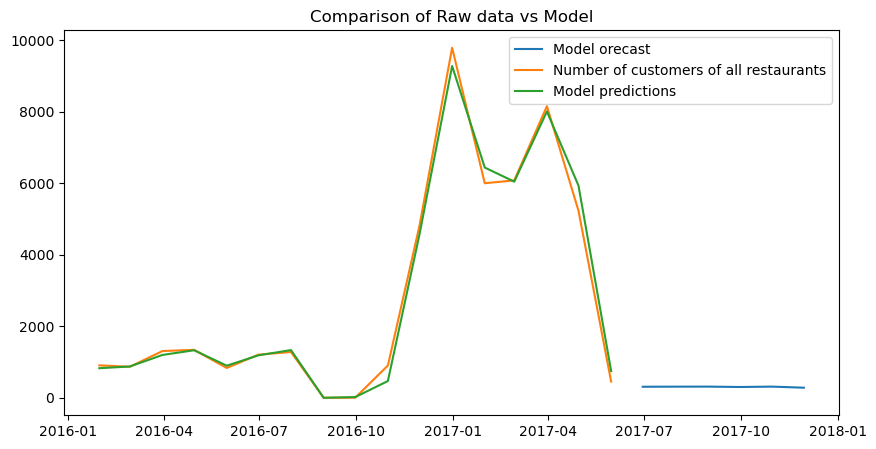

In [310]:
plt.figure(figsize=(10,5))
plt.plot(forecast_m, label = 'Model orecast')
plt.plot(df_grouped_m, label = 'Number of customers of all restaurants')
plt.plot(predicted_m, label = 'Model predictions')
plt.title('Comparison of Raw data vs Model')
plt.legend()
plt.show()

## Forecast of the sum of visitors of all restaurants for the next six months

In [311]:
print(forecast_m)

2017-06-30    308.406332
2017-07-31    310.994227
2017-08-31    312.138427
2017-09-30    301.659446
2017-10-31    311.765233
2017-11-30    281.606112
Freq: M, Name: predicted_mean, dtype: float64


We can see that, as the trend of the data suggests, the model forecasts lower and lower numbers of visitors for the restaurants.

In [281]:
mae = mean_absolute_error(df_grouped, predicted)
mape = mean_absolute_percentage_error(df_grouped, predicted)
rmse = np.sqrt(mean_squared_error(df_grouped, predicted))

print(f'Mean absolute error {mae}')
print(f'Mean absolute percentage error {mape}')
print(f'Root mean squared error {rmse}')

Mean absolute error 111.81590220846662
Mean absolute percentage error 0.8637383724556803
Root mean squared error 166.56894377730012


We can see that the mean absolute error is 111.8 it is a large number that indicate us a big variablity in our prediction and the mean, similarly to the root mean squared error as the metric is telling us that the residuals have a large stadard deviation (of 166.56); additionally, we can see a mean absolute percentage error of 86.3% this metric is indicating us that the average absolute percentage difference between the predictions and the actual values is 86%, in other words that the model's predictions are, on average, off by 86% from the real values.

The next steps for this forecast would be to try other methods like simplier time series model like AR, MA, or more complex ones; then, use the different metrics to determine which one does better predictions and decide which model is more accurate to use.